## Classification points using sklearn datasets
Steps purpose of this project:
1. Create a population of points with 2D for classificate as: red (bigger) and blue (lower) points based on distance from the center.
2. Create the model and find the best model for predictions.
3. Test our model with and do predictions.
4. Show the results

In [1]:
import tensorflow as tf
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import pandas as pd 



### Step 1: create the population of points

In [2]:
# Make 1000 examples
n_samples = 1000
# Create samples
X,y = make_circles(n_samples, noise=0.03, random_state=42 )

In [3]:
#transforming data into a dataframe
circles = pd.DataFrame({'X0': X[:, 0], 'X1': X[:, 1], 'label': y})
circles

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


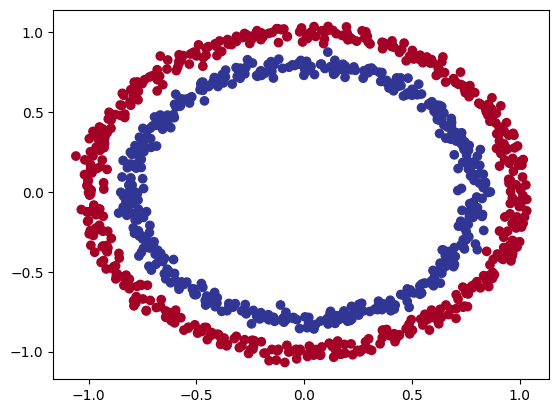

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu )

In [5]:
# Check the shapes of features and labels
X.shape, y.shape

((1000, 2), (1000,))

**Hint** : use https://playground.tensorflow.org/ to show how many diferent ways we can create models to classify this problem 

### Step 2: create and test diferents types of models

In [6]:
tf.random.set_seed(42)

model = tf.keras.Sequential(
    tf.keras.layers.Dense(1)
)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy']
)
model.fit(X,y, epochs=5 ,verbose=0)
model.evaluate(X,y)




32/32 [==============================] - 1s 10ms/step - loss: 0.6955 - accuracy: 0.4990


[0.6955140233039856, 0.49900001287460327]

The model sounds like guessing, because its accuracy is getting around ~50%. So We need to improve the model performing

In [7]:
tf.random.set_seed(42)

## adding more neurons for tracking
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(100, ),
    tf.keras.layers.Dense(10, ),
    tf.keras.layers.Dense(1,   )
])
# changing the optimizer to Adam
model_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
## adding more epochs to train the modal
model_2.fit(X,y, epochs=100 ,verbose=0)
model_2.evaluate(X,y)

32/32 [==============================] - 1s 6ms/step - loss: 0.7037 - accuracy: 0.5050


[0.703715980052948, 0.5049999952316284]

to visualize our model's predictions, let's create a function `plot_decision_boundary`, this function will:

* Take in a trained model, features (X) and labels (y)
* Create a mashgrid of the different X values
* Make predictions across the meshgrid
* Plot the predictions as well as a line between zones (where  each unique class falls)



In [8]:
import numpy as np

In [9]:
def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

  1/313 [..............................] - ETA: 1:55

313/313 [==============================] - 2s 5ms/step
doing binary classifcation...


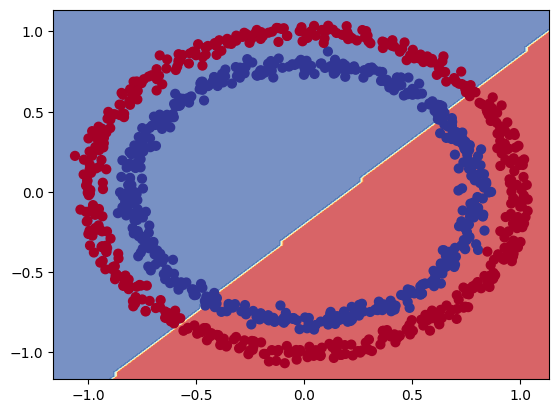

In [10]:
plot_decision_boundary(model_2,X,y)

In [11]:
# nx, ny = (3, 3)
# x = np.linspace(0, 1, nx)
# y = np.linspace(0, 1, ny)
# xv, yv = np.meshgrid(x, y)
# print(x)
# print(y ,'\n')
# print(xv)
# print(yv ,'\n')
# print(xv.ravel())
# print(yv.ravel(), '\n') 
# print(np.c_[xv, yv])



### Missing Piece: Non-linearity

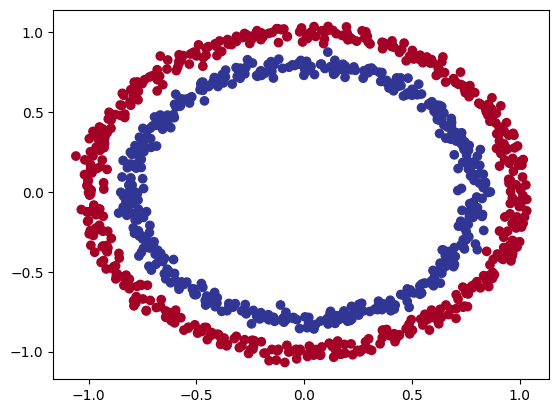

In [12]:
# Check out our data
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu )

In [13]:
tf.random.set_seed(42)

## adding more neurons for tracking
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='linear' ),
])
# changing the optimizer to Adam
model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
## adding more epochs to train the modal
history = model_3.fit(X,y, epochs=100 ,verbose=0)
model_3.evaluate(X,y)

32/32 [==============================] - 0s 3ms/step - loss: 6.1474 - accuracy: 0.4900


[6.147402286529541, 0.49000000953674316]

313/313 [==============================] - 1s 3ms/step
doing binary classifcation...


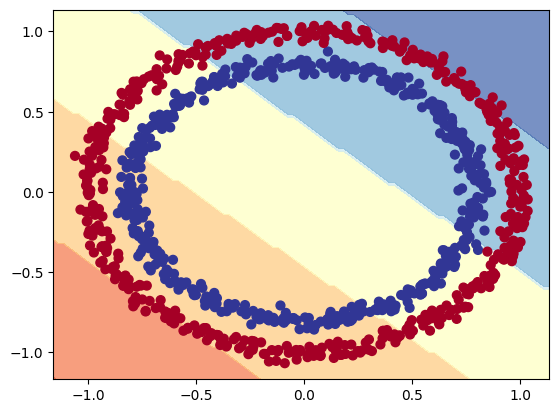

In [14]:
plot_decision_boundary(model_3, X, y)

lets try to create a our first neural network with a non-linear activation function. Use TF.playground to check out how to change hyperparameters can help us to find the best model

In [15]:
tf.random.set_seed(42)

## changing the activation function
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='relu'  ),
])
# changing the optimizer to Adam
model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
## adding more epochs to train the modal
history = model_4.fit(X,y, epochs=100 ,verbose=0)
model_4.evaluate(X,y)

32/32 [==============================] - 0s 2ms/step - loss: 0.7376 - accuracy: 0.4890


[0.7375591397285461, 0.48899999260902405]

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


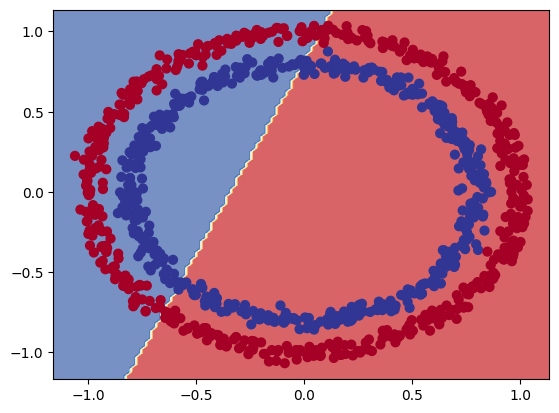

In [16]:
plot_decision_boundary(model_4, X, y)

In [17]:
tf.random.set_seed(42)

## adding more neurons for tracking
model_5 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1,  ),
])
# changing the optimizer to Adam
model_5.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
## adding more epochs to train the modal
history = model_5.fit(X,y, epochs=100 ,verbose=1)
model_5.evaluate(X,y)

Epoch 1/100
32/32 [==============================] - 2s 3ms/step - loss: 4.5958 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 3.6993 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 2.3678 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 1.7007 - accuracy: 0.5000
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 1.5852 - accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 1.4807 - accuracy: 0.5000
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 1.3413 - accuracy: 0.5000
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 1.1550 - accuracy: 0.5000
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9765 - accuracy: 0.5000
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8781 - accuracy: 0.5000
Epoch 11/

[0.6450628638267517, 0.6029999852180481]

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


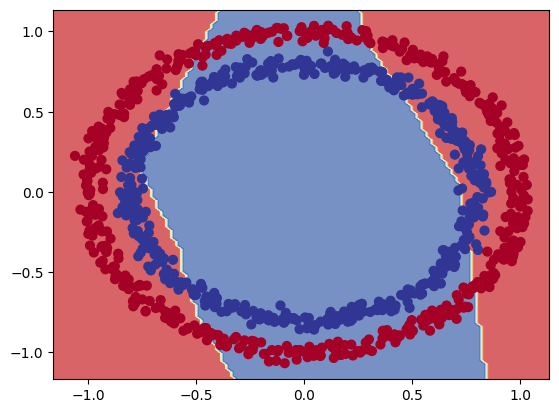

In [18]:
plot_decision_boundary(model_5, X, y)

In [19]:
tf.random.set_seed(42)

## adding more neurons for tracking
model_6 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1, activation='sigmoid'  ),
])
# changing the optimizer to Adam
model_6.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)
## adding more epochs to train the modal
history = model_6.fit(X,y, epochs=100 ,verbose=1)
model_6.evaluate(X,y)

Epoch 1/100
32/32 [==============================] - 1s 4ms/step - loss: 0.7096 - accuracy: 0.4980
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7040 - accuracy: 0.4860
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.7006 - accuracy: 0.4770
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6986 - accuracy: 0.4490
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6973 - accuracy: 0.4840
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6963 - accuracy: 0.4780
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6954 - accuracy: 0.4740
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6948 - accuracy: 0.4730
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 0.6940 - accuracy: 0.4690
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4800
Epoch 11/

[0.5883924961090088, 0.7599999904632568]

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


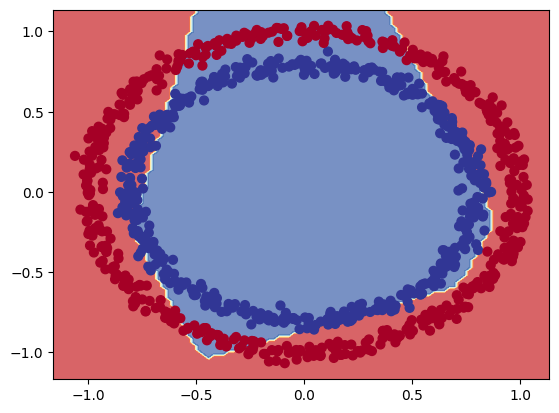

In [20]:
plot_decision_boundary(model_6, X, y)

🤔 **question**: what's wrong the predictions we've made? Are we really evaluating our model correctly? Hint: what data did the modal learn on and what data did we predict on?
- **Answer**: we dont separate train and test data

🔑 **Note**: The combination of **linear (straight lines) and non-linear (non-straight lines) functions** is one of the key fundamentals of neurals networks.

Now we've discuseed the concept of linear and non-linear functions, let's see them in action


In [21]:
# Create a toy a tensor (similar to the data we pass into our models)
A = tf.cast(tf.range(-10,10 ), tf.float32)
A

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
      dtype=float32)>

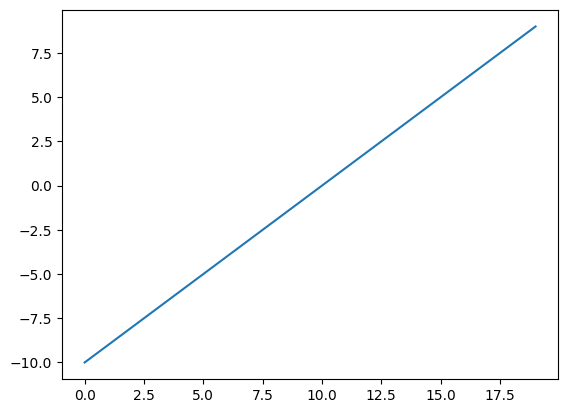

In [22]:
# Visualize our toy tensor
plt.plot(A)
plt.show()

Let's start by replicating sigmoid -  `sigmoid(x) = 1 / (1 + exp(-x))`

In [23]:
def sigmoid(x):
    return 1 / (1 + tf.exp(-x)) 

# use your sigmoid fuction on our tensor
sigmoid(A)


<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([4.5397872e-05, 1.2339458e-04, 3.3535014e-04, 9.1105117e-04,
       2.4726233e-03, 6.6928510e-03, 1.7986210e-02, 4.7425874e-02,
       1.1920292e-01, 2.6894143e-01, 5.0000000e-01, 7.3105860e-01,
       8.8079703e-01, 9.5257413e-01, 9.8201376e-01, 9.9330717e-01,
       9.9752742e-01, 9.9908900e-01, 9.9966466e-01, 9.9987662e-01],
      dtype=float32)>

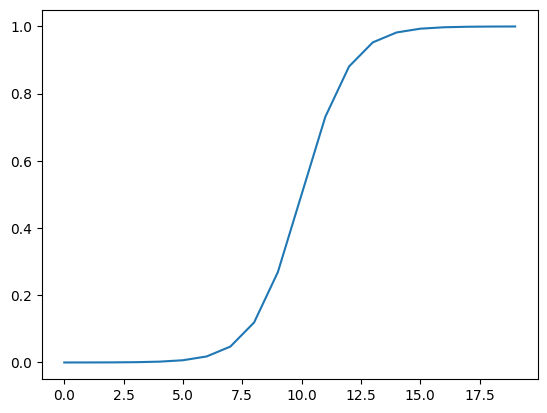

In [24]:
# Plot A tensor transformed by sigmoid
plt.plot(sigmoid(A))
plt.show()

Let's recreate the relu function `relu(x) = max(x,0)`

In [25]:
def relu(x):
    return tf.maximum(x,0)
# use your relu fuction on our tensor
relu(A)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6.,
       7., 8., 9.], dtype=float32)>

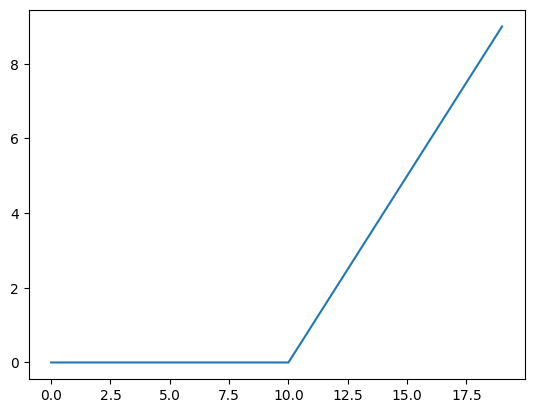

In [26]:
plt.plot(relu(A))
plt.show()

## Step 3: test your model

Lets check out our model performing with test data

In [27]:
X_train, y_train  = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [28]:
tf.random.set_seed(42)

## Create the model (same as model_6)
model_7 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
# changing the optimizer to Adam and learning rate
model_7.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)
## reducing the number of epochs 
history = model_7.fit(X_train,y_train, epochs=25 ,verbose=1)

## evalute the modelon test dataset
model_7.evaluate(X_test,y_test)

Epoch 1/25
25/25 [==============================] - 1s 5ms/step - loss: 0.6876 - accuracy: 0.5088
Epoch 2/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6822 - accuracy: 0.5462
Epoch 3/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.5512
Epoch 4/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6718 - accuracy: 0.5625
Epoch 5/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6656 - accuracy: 0.6025
Epoch 6/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6603 - accuracy: 0.5625
Epoch 7/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6543 - accuracy: 0.6100
Epoch 8/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6494 - accuracy: 0.6363
Epoch 9/25
25/25 [==============================] - 0s 5ms/step - loss: 0.6410 - accuracy: 0.6137
Epoch 10/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6308 - accuracy: 0.6388
Epoch 11/25
25/25 [

[0.4209194481372833, 0.8299999833106995]

313/313 [==============================] - 1s 3ms/step
doing binary classifcation...
313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


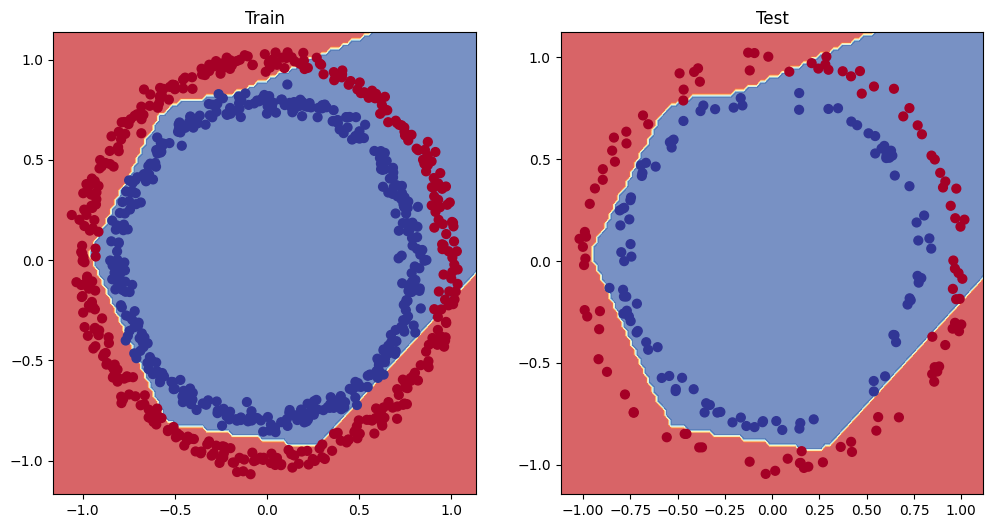

In [29]:
#lets check the differences between training and text data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_7, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_7, X_test, y_test)
plt.show()


## Step 4: Show the results

In [30]:
## convert the history object into a Dataframe
pd.DataFrame(history.history)

,loss,accuracy
0,0.687608,0.50875
1,0.682203,0.54625
2,0.676707,0.55125
3,0.671787,0.56250
4,0.665615,0.60250
5,0.660338,0.56250
6,0.654334,0.61000
7,0.649396,0.63625
8,0.641009,0.61375
9,0.630775,0.63875


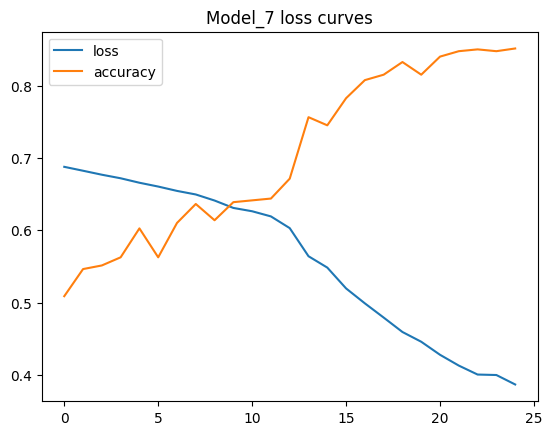

In [31]:
# plot the model 7 performing
pd.DataFrame(history.history).plot()
plt.title("Model_7 loss curves")
plt.show()

🔑 **Note**: for many problems, the loss function going down means the model is improving (the predictions it's making are getting closer to ground truth labels)

### finding the best learning rate 

To find the ideal learning rate (the learning rate where the loss decreases the most during training) we're going to use the following steps:
* A learning rate **callback** - you can think a callback as an extra piece funcionality, you can add do your model *while* its training
* Another model (we could use the same one as above, but we're practing building models here)
* A modified loss curves plot

In [32]:
tf.random.set_seed(42)

## Create the model (same as model_7)
model_8 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1, activation='sigmoid'  ),
])

model_8.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

#Create a learning rate callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch/20))

history_8 = model_8.fit(X_train,y_train, epochs=100 ,verbose=1, callbacks=lr_scheduler)

model_8.evaluate(X_test,y_test)


Epoch 1/100
25/25 [==============================] - 1s 6ms/step - loss: 0.7007 - accuracy: 0.5025 - lr: 1.0000e-04
Epoch 2/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.5000 - lr: 1.1220e-04
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.4988 - lr: 1.2589e-04
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6996 - accuracy: 0.4938 - lr: 1.4125e-04
Epoch 5/100
25/25 [==============================] - 0s 4ms/step - loss: 0.6993 - accuracy: 0.4988 - lr: 1.5849e-04
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.4950 - lr: 1.7783e-04
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.4925 - lr: 1.9953e-04
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.4988 - lr: 2.2387e-04
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss

[0.6933738589286804, 0.4950000047683716]

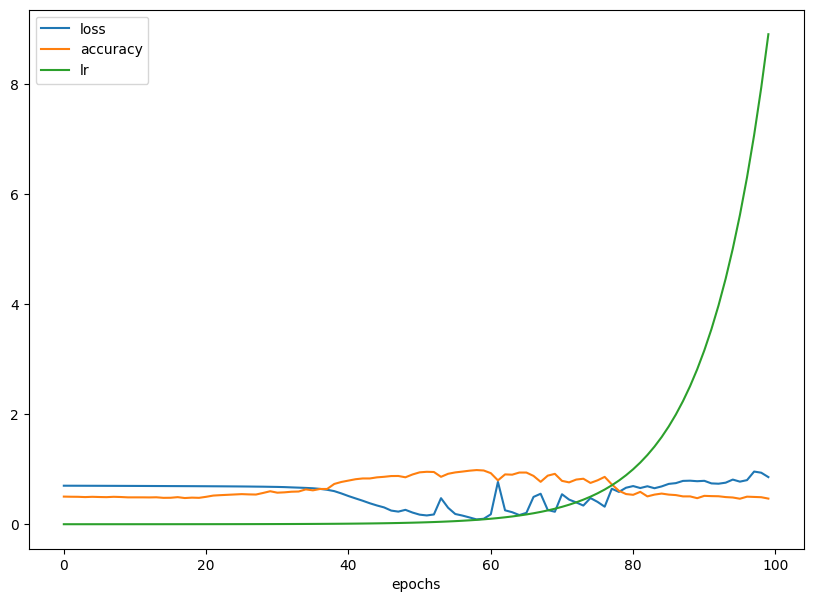

In [33]:
pd.DataFrame(history_8.history).plot(figsize=(10,7), xlabel="epochs")
plt.show()

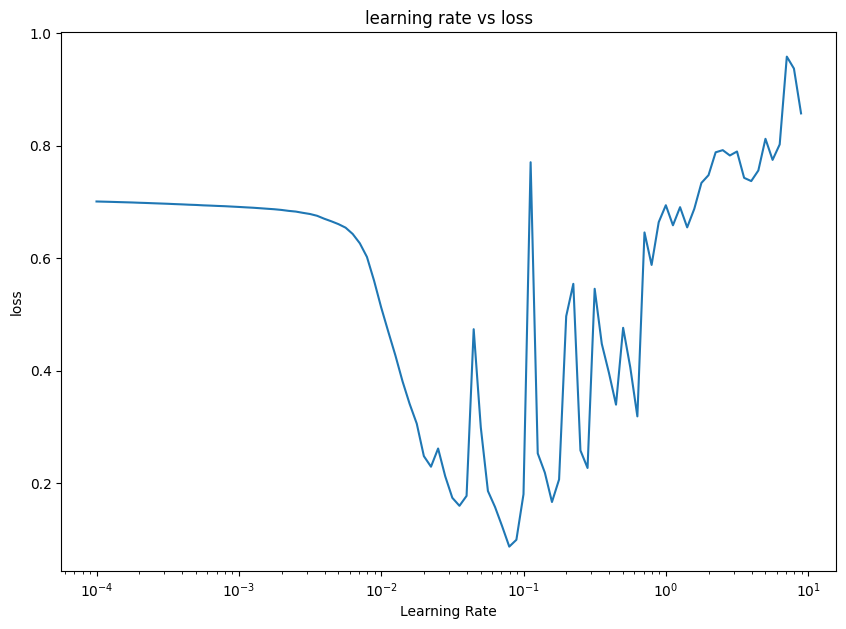

In [34]:
#plot the learning rate versus the loss
lrs = 1e-4  * (10 ** (tf.range(100)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history_8.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('loss')
plt.title('learning rate vs loss')
plt.show()

In [35]:
## Let's try  using a higher *ideal learning rate with the same modal as before

tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(4, activation='relu' ),
    tf.keras.layers.Dense(1, activation='sigmoid'  ),
])

model_9.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
    metrics=['accuracy']
)

history_8 = model_9.fit(X_train,y_train, epochs=20 ,verbose=1)

model_9.evaluate(X_test,y_test)

Epoch 1/20
25/25 [==============================] - 1s 4ms/step - loss: 0.6894 - accuracy: 0.5350
Epoch 2/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6863 - accuracy: 0.5275
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6762 - accuracy: 0.5550
Epoch 4/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6612 - accuracy: 0.5938
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 0.6383 - accuracy: 0.6475
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 0.6097 - accuracy: 0.7113
Epoch 7/20
25/25 [==============================] - 0s 2ms/step - loss: 0.5737 - accuracy: 0.7588
Epoch 8/20
25/25 [==============================] - 0s 2ms/step - loss: 0.5185 - accuracy: 0.7650
Epoch 9/20
25/25 [==============================] - 0s 2ms/step - loss: 0.4431 - accuracy: 0.8112
Epoch 10/20
25/25 [==============================] - 0s 2ms/step - loss: 0.3625 - accuracy: 0.8988
Epoch 11/20
25/25 [

[0.13931770622730255, 0.949999988079071]

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


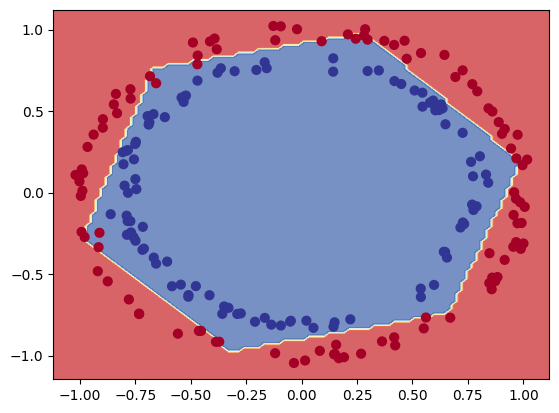

In [36]:
plot_decision_boundary(model_9,X_test,y_test)

In [37]:
## compore the 2 best models
print(model_7.evaluate(X_test,y_test))
print(model_9.evaluate(X_test,y_test))

7/7 [==============================] - 0s 3ms/step - loss: 0.4209 - accuracy: 0.8300
[0.4209194481372833, 0.8299999833106995]
7/7 [==============================] - 0s 3ms/step - loss: 0.1393 - accuracy: 0.9500
[0.13931770622730255, 0.949999988079071]


313/313 [==============================] - 1s 3ms/step
doing binary classifcation...
313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


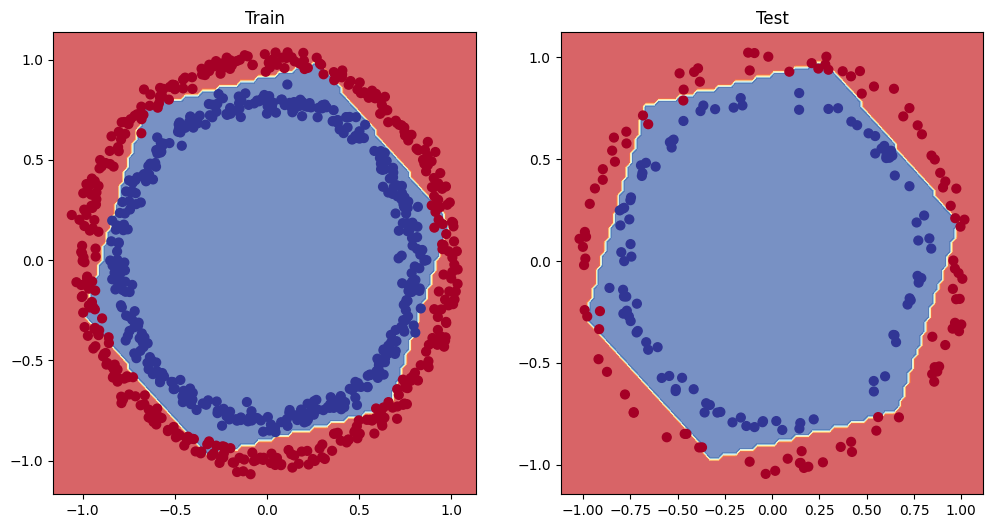

In [38]:
#lets check the differences between training and text data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_9, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_9, X_test, y_test)
plt.show()
